# 기본 준비

## 라이브러리 및 환경설정

In [5]:
# 기본라이브러리 import
from google.colab import drive
import os, json, pickle
import subprocess
import itertools
import hashlib
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.metrics import f1_score, roc_curve, auc, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import learning_curve

In [ ]:
!wget https://didierstevens.com/files/software/pdfid_v0_2_10.zip
!unzip pdfid_v0_2_10.zip -d pdfid

--2025-08-01 03:44:19--  https://didierstevens.com/files/software/pdfid_v0_2_10.zip
Resolving didierstevens.com (didierstevens.com)... 148.113.201.69
Connecting to didierstevens.com (didierstevens.com)|148.113.201.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11935 (12K) [application/zip]
Saving to: ‘pdfid_v0_2_10.zip’

pdfid_v0_2_10.zip   100%[===================>]  11.66K  --.-KB/s    in 0s      

2025-08-01 03:44:19 (195 MB/s) - ‘pdfid_v0_2_10.zip’ saved [11935/11935]

Archive:  pdfid_v0_2_10.zip
 extracting: pdfid/pdfid.ini         
  inflating: pdfid/pdfid.py          
  inflating: pdfid/plugin_embeddedfile.py  
  inflating: pdfid/plugin_list       
  inflating: pdfid/plugin_nameobfuscation.py  
  inflating: pdfid/plugin_triage.py  


In [ ]:
!wget https://raw.githubusercontent.com/DidierStevens/DidierStevensSuite/master/pdf-parser.py

--2025-08-11 01:19:29--  https://raw.githubusercontent.com/DidierStevens/DidierStevensSuite/master/pdf-parser.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78373 (77K) [text/plain]
Saving to: ‘pdf-parser.py’

pdf-parser.py       100%[===================>]  76.54K  --.-KB/s    in 0.004s  

2025-08-11 01:19:29 (20.4 MB/s) - ‘pdf-parser.py’ saved [78373/78373]



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
colab_path = '/content/drive/MyDrive/haksul/notebook/'
pdfdata_path = '/content/pdfdata/'
pdfid_path = './pdfid/pdfid.py'
pdf_parser_path= './pdf-parser.py'

In [3]:
pd.set_option('display.max_columns', None)

NameError: name 'pd' is not defined

## 데이터 불러오기

In [ ]:
!mkdir -p /content/pdfdata

!unzip "{colab_path}data_orig/pdfdata.zip" -d /content/pdfdata

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/pdfdata/i8952.pdf  
  inflating: /content/pdfdata/VirusShare_03409190e84a6e9b30992ec18f62c3a2  
  inflating: /content/pdfdata/VirusShare_bb42430da4bc4d9c68df432040e683af  
  inflating: /content/pdfdata/VirusShare_2632fff87d25de31179298de32c86222  
  inflating: /content/pdfdata/VirusShare_acc036ce331e94dec73dd692aa8fabdf  
  inflating: /content/pdfdata/VirusShare_894d147179ca934e5007fcf4ea49b8ca  
  inflating: /content/pdfdata/VirusShare_a109b4c23e9756f3d7f24f562a19cb66  
  inflating: /content/pdfdata/VirusShare_83408dd72035a19c285169525e210fb1  
  inflating: /content/pdfdata/VirusShare_4587e96e01ca82533a8641371371918f  
  inflating: /content/pdfdata/rp-10-18.pdf  
  inflating: /content/pdfdata/nc-pia.pdf  
  inflating: /content/pdfdata/VirusShare_339f31f3e4f80dc0a8cb5f6366456d89  
  inflating: /content/pdfdata/acbj.pdf  
  inflating: /content/pdfdata/VirusShare_390f2209abd4c38066bbbbd7d7757585  
  inflating: /content/pdfdata/Vir

In [ ]:
# 새로 feature를 뽑을 것이므로, 기존에 있던 feature는 지움

df = pd.read_csv(colab_path + "data_orig/pdfdata.csv",index_col='filename')
df = df[df['source'] != 'Contagio'] # Contagio는 중복 데이터 때문에 열 제외

columns_to_keep = ['label', 'source']
columns_to_drop = [col for col in df.columns if col not in columns_to_keep]
df = df.drop(columns=columns_to_drop)

df

,label,source
filename,,
rp-11-41.pdf,0,CIC
rp-09-51.pdf,0,CIC
n-10-69.pdf,0,CIC
f8594.pdf,0,CIC
n-09-50.pdf,0,CIC
...,...,...
VirusShare_280d5f39c217d8501626adc86221c752,1,virustotal
VirusShare_c1bbc46bc72890d301469dd7d281b019,1,virustotal
VirusShare_8c831c5f1b28e66f132385692aebe59c,1,virustotal


In [ ]:
# 현재 virustotal에서 가져온 악성 pdf 데이터 19853개 <- balance를 맞추기 위해 일부 cut 할 수도?
#      CIC에서 가져온 정상 pdf 데이터 7500개
label_counts_by_source = df.groupby(['source', 'label']).size().unstack(fill_value=0)
display(label_counts_by_source)

label,0,1
source,,
CIC,7500,0
virustotal,0,19853


## 데이터 무결성 검증

In [ ]:
# df에 대한 실제 pdf파일의 누락을 봄.
# 일단 수 비교부터 한다.
# 실제 pdf data >= df의 열 이므로 잘 match되는지만 확인

num_files_in_pdfdata = len([f for f in os.listdir(pdfdata_path) if os.path.isfile(os.path.join(pdfdata_path, f))])

print(f"실제 파일의 수: {pdfdata_path}: {num_files_in_pdfdata}")
print(f"df에 있는 열의 수: {df.shape[0]}")

실제 파일의 수: /content/pdfdata/: 27500
df에 있는 열의 수: 27353


In [ ]:
# data와 df가 잘 match되나 확인

df_filenames = df.index.tolist()

files_in_df_not_present_in_pdfdata = []

for filename in df_filenames:
    file_path = os.path.join(pdfdata_path, filename)
    if not os.path.exists(file_path):
        files_in_df_not_present_in_pdfdata.append(filename)

print(f"df에 없는 데이터: {len(files_in_df_not_present_in_pdfdata)}")


df에 없는 데이터: 0


# feature engineering

In [ ]:
# feature extract 용 복사본 생성 및 초기화
df_feature = df.copy()
df_feature['is_pdf'] = np.nan
df_feature['error'] = False
df_feature['size'] = np.nan
df_feature['obj_diff'] = np.nan
df_feature['stream_diff'] = np.nan
df_feature['xref_diff'] = np.nan

pdfid_feature_columns = [
    'obj', 'endobj', 'stream', 'endstream', 'xref', 'trailer', 'startxref',
    '/Page', '/Encrypt', '/ObjStm', '/JS', '/JavaScript', '/AA', '/OpenAction',
    '/AcroForm', '/JBIG2Decode', '/RichMedia', '/Launch', '/EmbeddedFile',
    '/XFA', '/URI', '/Colors > 2^24'
]

pdf_parser_columns = ['JS_entropy']

for col in pdfid_feature_columns:
    df_feature[col] = np.nan

for col in pdf_parser_columns:
    df_feature[col] = np.nan

df_feature

,label,source,is_pdf,error,size,obj_diff,stream_diff,xref_diff,obj,endobj,stream,endstream,xref,trailer,startxref,/Page,/Encrypt,/ObjStm,/JS,/JavaScript,/AA,/OpenAction,/AcroForm,/JBIG2Decode,/RichMedia,/Launch,/EmbeddedFile,/XFA,/URI,/Colors > 2^24,JS_entropy
filename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
rp-11-41.pdf,0,CIC,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rp-09-51.pdf,0,CIC,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n-10-69.pdf,0,CIC,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
f8594.pdf,0,CIC,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n-09-50.pdf,0,CIC,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VirusShare_280d5f39c217d8501626adc86221c752,1,virustotal,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VirusShare_c1bbc46bc72890d301469dd7d281b019,1,virustotal,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VirusShare_8c831c5f1b28e66f132385692aebe59c,1,virustotal,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## feature 뽑기 - pdfid

In [ ]:
def extract_feature(filename, dataframe = df_feature):
    pdf_path = os.path.join(pdfdata_path, filename)

    # pdf 파일 사이즈 구하기
    try:
      dataframe.loc[filename, 'size'] = os.path.getsize(pdf_path)
    except:
      dataframe.loc[filename, 'error'] = True
      return

    # pdfid로 정보 뽑기
    try:
        result = subprocess.run(['python', pdfid_path, pdf_path], capture_output=True, text=True, check=True)

        features = {}
        for line in result.stdout.strip().split('\n'):
            if line.startswith(' '):
                parts = line.strip().split()
                if len(parts) >= 2 and parts[-1].isdigit():
                    feature_name = ' '.join(parts[:-1])
                    feature_count = int(parts[-1])
                    features[feature_name] = feature_count
        for key, val in features.items():
            if key in dataframe.columns:
                dataframe.loc[filename, key] = val
        dataframe.loc[filename, 'is_pdf'] = True

    # diff 정보
        df_feature['obj_diff'] = (df_feature['obj'] - df_feature['endobj']).abs()
        df_feature['stream_diff'] = (df_feature['stream'] - df_feature['endstream']).abs()
        df_feature['xref_diff'] = (df_feature['xref'] - df_feature['startxref']).abs()

    except subprocess.CalledProcessError as e:
        dataframe.loc[filename, 'error'] = True
        return
    except Exception as e:
        dataframe.loc[filename, 'error'] = True
        return

In [ ]:
# extract_feature 시험용
extract_feature('cp120_korean.pdf')
display(df_feature.loc[['cp120_korean.pdf']])

,label,source,is_pdf,error,size,obj,endobj,stream,endstream,xref,...,/AA,/OpenAction,/AcroForm,/JBIG2Decode,/RichMedia,/Launch,/EmbeddedFile,/XFA,/URI,/Colors > 2^24
filename,,,,,,,,,,,,,,,,,,,,,
cp120_korean.pdf,0,CIC,True,False,118275.0,40.0,40.0,20.0,20.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Iterate through all filenames in df_feature index and extract features
total_files = len(df_feature.index)
print(f"Starting feature extraction for {total_files} files...")

for i, filename in enumerate(df_feature.index):
    if (i + 1) % 100 == 0 or (i + 1) == total_files:
        print(f"Processing file {i + 1}/{total_files}: {filename}")
    # Pass the filename string to the extract_feature function
    extract_feature(filename)


df_feature

Starting feature extraction for 27353 files...
Processing file 100/27353: n-08-94.pdf
Processing file 200/27353: 041413future-music-coalition.pdf
Processing file 300/27353: f8283v_accessible.pdf
Processing file 400/27353: n-07-34.pdf
Processing file 500/27353: comvir.pdf
Processing file 600/27353: rp-07-10.pdf
Processing file 700/27353: baydncc.pdf
Processing file 800/27353: irb10-34.pdf
Processing file 900/27353: f8633.pdf
Processing file 1000/27353: i1120pm3.pdf
Processing file 1100/27353: assjunlea.pdf
Processing file 1200/27353: f8872_accessible.pdf
Processing file 1300/27353: 284.pdf
Processing file 1400/27353: irb12-07.pdf
Processing file 1500/27353: rr-03-109.pdf
Processing file 1600/27353: casscopc.pdf
Processing file 1700/27353: clevlnlv.pdf
Processing file 1800/27353: 20101105-B-Hebden.pdf
Processing file 1900/27353: n-08-98.pdf
Processing file 2000/27353: Aptherlc.pdf
Processing file 2100/27353: n-08-32.pdf
Processing file 2200/27353: rp-02-67.pdf
Processing file 2300/27353:

,label,source,is_pdf,error,size,obj,endobj,stream,endstream,xref,...,/AA,/OpenAction,/AcroForm,/JBIG2Decode,/RichMedia,/Launch,/EmbeddedFile,/XFA,/URI,/Colors > 2^24
filename,,,,,,,,,,,,,,,,,,,,,
rp-11-41.pdf,0,CIC,True,False,65867.0,112.0,112.0,33.0,33.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
rp-09-51.pdf,0,CIC,True,False,16457.0,34.0,34.0,9.0,9.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n-10-69.pdf,0,CIC,True,False,15739.0,22.0,22.0,5.0,5.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
f8594.pdf,0,CIC,True,False,87068.0,222.0,222.0,108.0,108.0,3.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
n-09-50.pdf,0,CIC,True,False,46393.0,79.0,79.0,23.0,23.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VirusShare_280d5f39c217d8501626adc86221c752,1,virustotal,True,False,369652.0,46.0,46.0,8.0,8.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0
VirusShare_c1bbc46bc72890d301469dd7d281b019,1,virustotal,True,False,92201.0,8.0,8.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
VirusShare_8c831c5f1b28e66f132385692aebe59c,1,virustotal,True,False,12327.0,9.0,9.0,2.0,2.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 추출 데이터 저장

In [ ]:
# 추출 데이터 저장
# (이미 저장해서 데이터 손상 방지 위해 주석처리)
# 앞으로는 학습 데이터에서 extract하는게 아니라 바로 이거 불러오기.
#df_feature.to_csv(colab_path + 'data_feature/feature_pdfid.csv')

In [ ]:
df_feature = pd.read_csv(colab_path + "data_feature/feature_pdfid.csv", index_col='filename')

### feature 요소 확인

In [ ]:
# 음성: 0, 악성: 1 에 따른 feature의 평균값 보기
feature_columns_numeric = df_feature.select_dtypes(include=np.number).columns.tolist()
if 'label' in feature_columns_numeric:
    feature_columns_numeric.remove('label')

average_features_by_label = df_feature.groupby('label')[feature_columns_numeric].mean()

print("Average feature values by label:")
display(average_features_by_label)

Average feature values by label:


,size,obj,endobj,stream,endstream,xref,trailer,startxref,/Page,/Encrypt,/ObjStm,/JS,/JavaScript,/AA,/OpenAction,/AcroForm,/JBIG2Decode,/RichMedia,/Launch,/EmbeddedFile,/XFA,/URI,/Colors > 2^24
label,,,,,,,,,,,,,,,,,,,,,,,
0,95500.252400,90.727697,90.725963,21.263368,21.262568,1.949860,1.949860,1.888652,6.702760,0.011468,0.778904,0.215362,0.246966,0.374450,0.090145,0.244166,0.051207,0.00000,0.012135,0.030271,0.000800,2.816642,0.000000
1,51155.192565,40.196998,40.193119,8.039289,8.008059,1.665995,1.677328,1.422455,2.096125,0.000756,0.006699,0.337974,0.489063,0.013049,0.114609,0.330092,0.000655,0.00267,0.000856,0.630327,0.216841,19.416713,0.000201


## feature 뽑기 - pdf-parser

In [ ]:
!python3 pdf-parser.py /content/pdfdata/VirusShare_8c831c5f1b28e66f132385692aebe59c -c

PDF Comment '%PDF-1.6\r\n'

PDF Comment '%\xe2\xe3\xcf\xd3\r\n'

obj 7 0
 Type: /Pages
 Referencing: 28 0 R

  <<
    /Count 1
    /Type /Pages
    /Kids [28 0 R]
  >>


<</Count 1/Type/Pages/Kids[28 0 R]>>


obj 21 0
 Type: /Catalog
 Referencing: 23 0 R, 22 0 R, 7 0 R, 11 0 R

  <<
    /Names 23 0 R
    /AcroForm 22 0 R
    /Pages 7 0 R
    /OCProperties
      <<
        /D
          <<
            /RBGroups []
          >>
      >>
    /StructTreeRoot 11 0 R
    /Type /Catalog
  >>


<</Names 23 0 R/AcroForm 22 0 R/Pages 7 0 R/OCProperties<</D<</RBGroups[]>>>>/StructTreeRoot 11 0 R/Type/Catalog>>


obj 23 0
 Type: 
 Referencing: 24 0 R, 8 0 R

  <<
    /JavaScript 24 0 R
    /AP 8 0 R
  >>


<</JavaScript 24 0 R/AP 8 0 R>>


obj 24 0
 Type: 
 Referencing: 123 0 R, 76 0 R

  <<
    /Names [123 0 R 76 0 R]
  >>


<</Names[123 0 R 76 0 R]>>


obj 25 0
 Type: 
 Referencing: 26 0 R

  <<
    /S /JavaScript
    /JS 26 0 R
  >>


<</S/JavaScript/JS 26 0 R>>


obj 26 0
 Type: 
 Referencing: 

In [ ]:
!python3 pdf-parser.py /content/pdfdata/VirusShare_8c831c5f1b28e66f132385692aebe59c -s EmbeddedFiles --regex --searchstream --unfiltered

In [ ]:
# 예시
!python3 pdf-parser.py /content/pdfdata/cp120_korean.pdf -s /JavaScript

In [ ]:
!python3 pdf-parser.py /content/pdfdata/VirusShare_8c831c5f1b28e66f132385692aebe59c --search "MZ"

In [ ]:
def search_mz_pk_in_pdf(filename, pdf_parser_path=pdf_parser_path, pdfdata_path= pdfdata_path):
    pdf_file_path = os.path.join(pdfdata_path, filename)

    if not os.path.exists(pdf_file_path):
        error_message = f"Error: File not found at {pdf_file_path}"
        return error_message, error_message # Return error for both searches

    mz_output = None
    pk_output = None

    try:
        # Search for "MZ"
        result_mz = subprocess.run(
            ['python3', pdf_parser_path, pdf_file_path, '--search', 'MZ'],
            capture_output=True,
            check=True,
            text=True,
            timeout=60
        )
        mz_output = result_mz.stdout

    except subprocess.CalledProcessError as e:
        mz_output = f"Error executing pdf-parser.py for {filename} searching for 'MZ': {e.stderr}"
    except FileNotFoundError:
        mz_output = f"Error: pdf-parser.py not found at {pdf_parser_path}"
    except subprocess.TimeoutExpired:
        mz_output = f"Error: pdf-parser.py timed out for {filename} searching for 'MZ'"
    except Exception as e:
        mz_output = f"An unexpected error occurred for {filename} searching for 'MZ': {e}"

    try:
        # Search for "PK"
        result_pk = subprocess.run(
            ['python3', pdf_parser_path, pdf_file_path, '--search', 'PK'],
            capture_output=True,
            check=True,
            text=True,
            timeout=60
        )
        pk_output = result_pk.stdout

    except subprocess.CalledProcessError as e:
        pk_output = f"Error executing pdf-parser.py for {filename} searching for 'PK': {e.stderr}"
    except FileNotFoundError:
        # Avoid repeating the error message if the file was not found in the first place
        if "File not found" not in mz_output:
             pk_output = f"Error: pdf-parser.py not found at {pdf_parser_path}"
    except subprocess.TimeoutExpired:
         pk_output = f"Error: pdf-parser.py timed out for {filename} searching for 'PK'"
    except Exception as e:
        pk_output = f"An unexpected error occurred for {filename} searching for 'PK': {e}"


    return mz_output, pk_output


In [ ]:
# Add columns to store MZ and PK search results (e.g., boolean indicating presence)
df_feature['has_MZ'] = False
df_feature['has_PK'] = False

total_files = len(df_feature.index)
print(f"Starting MZ and PK search for {total_files} files...")

# Apply the search_mz_pk_in_pdf function to each filename in df_feature
for i, filename in enumerate(df_feature.index):
    if (i + 1) % 100 == 0 or (i + 1) == total_files:
        print(f"Processing file {i + 1}/{total_files}: {filename}")

    mz_result, pk_result = search_mz_pk_in_pdf(filename)

    if mz_result and not mz_result.startswith("Error"):
        df_feature.loc[filename, 'has_MZ'] = True
    if pk_result and not pk_result.startswith("Error"):
        df_feature.loc[filename, 'has_PK'] = True

    # Optionally, handle errors by marking the row or logging
    if mz_result and mz_result.startswith("Error"):
         print(f"Error processing {filename} for MZ: {mz_result}")
         df_feature.loc[filename, 'error'] = True # Mark as error if any search failed
    if pk_result and pk_result.startswith("Error"):
         print(f"Error processing {filename} for PK: {pk_result}")
         df_feature.loc[filename, 'error'] = True # Mark as error if any search failed


display(df_feature.head())

Starting MZ and PK search for 27353 files...
Processing file 100/27353: n-08-94.pdf
Processing file 200/27353: 041413future-music-coalition.pdf
Processing file 300/27353: f8283v_accessible.pdf
Processing file 400/27353: n-07-34.pdf
Processing file 500/27353: comvir.pdf
Processing file 600/27353: rp-07-10.pdf
Processing file 700/27353: baydncc.pdf
Processing file 800/27353: irb10-34.pdf
Processing file 900/27353: f8633.pdf
Processing file 1000/27353: i1120pm3.pdf
Processing file 1100/27353: assjunlea.pdf
Processing file 1200/27353: f8872_accessible.pdf
Processing file 1300/27353: 284.pdf
Processing file 1400/27353: irb12-07.pdf
Processing file 1500/27353: rr-03-109.pdf
Processing file 1600/27353: casscopc.pdf
Processing file 1700/27353: clevlnlv.pdf
Processing file 1800/27353: 20101105-B-Hebden.pdf
Processing file 1900/27353: n-08-98.pdf
Processing file 2000/27353: Aptherlc.pdf
Processing file 2100/27353: n-08-32.pdf
Processing file 2200/27353: rp-02-67.pdf
Error processing report1-38.p

,label,source,is_pdf,error,size,obj,endobj,stream,endstream,xref,trailer,startxref,/Page,/Encrypt,/ObjStm,/JS,/JavaScript,/AA,/OpenAction,/AcroForm,/JBIG2Decode,/RichMedia,/Launch,/EmbeddedFile,/XFA,/URI,/Colors > 2^24,has_MZ,has_PK
filename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
rp-11-41.pdf,0,CIC,True,False,65867.0,112.0,112.0,33.0,33.0,2.0,2.0,2.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
rp-09-51.pdf,0,CIC,True,False,16457.0,34.0,34.0,9.0,9.0,2.0,2.0,2.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
n-10-69.pdf,0,CIC,True,False,15739.0,22.0,22.0,5.0,5.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,False
f8594.pdf,0,CIC,True,False,87068.0,222.0,222.0,108.0,108.0,3.0,3.0,3.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True
n-09-50.pdf,0,CIC,True,False,46393.0,79.0,79.0,23.0,23.0,2.0,2.0,2.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False


### 추출 데이터 저장

In [ ]:
#df_feature.to_csv(colab_path + 'data_feature/feature_pdf_parser.csv')
df_feature = pd.read_csv(colab_path + "data_feature/feature_pdf_parser.csv", index_col='filename')

### feature 요소 확인

In [ ]:
print("Count of has_MZ by label:")
display(df_feature.groupby('label')['has_MZ'].value_counts().unstack(fill_value=0))

print("\nCount of has_PK by label:")
display(df_feature.groupby('label')['has_PK'].value_counts().unstack(fill_value=0))

Count of has_MZ by label:


has_MZ,0,1
label,,
0,7474,24
1,19691,160



Count of has_PK by label:


has_PK,0,1
label,,
0,7046,452
1,19227,624


## feature 다루기

In [ ]:
# obj, stream, xref는 자체의 크기보다는 각 차이가 중요하므로 새로운 feature로 추가
df_feature['obj_diff'] = (df_feature['obj'] - df_feature['endobj']).abs()
df_feature['stream_diff'] = (df_feature['stream'] - df_feature['endstream']).abs()
df_feature['xref_diff'] = (df_feature['xref'] - df_feature['startxref']).abs()

# diff 마다 악성에 얼마나 영향을 미치나 보기
# 대부분 differance가 있으면 악성
display(df_feature.groupby('obj_diff')['label'].value_counts().unstack(fill_value=0))
print("\n")
display(df_feature.groupby('stream_diff')['label'].value_counts().unstack(fill_value=0))
print("\n")
display(df_feature.groupby('xref_diff')['label'].value_counts().unstack(fill_value=0))

label,0,1
obj_diff,,
0.0,7486,19758
1.0,12,93
2.0,0,2
3.0,1,0


label,0,1
stream_diff,,
0.0,7492,19052
1.0,6,791
2.0,1,1
3.0,0,5
5.0,0,1
6.0,0,2
23.0,0,1


label,0,1
xref_diff,,
0.0,7182,16084
1.0,208,2486
2.0,89,1281
3.0,13,1
4.0,3,1
5.0,2,0
6.0,2,0


In [ ]:
# obj & endobj, stream & endstream, xref & xrefstart은 지우고 diff만 사용할거
df_feature = df_feature.drop(columns=['obj', 'endobj', 'stream', 'endstream', 'xref', 'trailer', 'startxref'])
df_feature

,label,source,is_pdf,error,size,/Page,/Encrypt,/ObjStm,/JS,/JavaScript,/AA,/OpenAction,/AcroForm,/JBIG2Decode,/RichMedia,/Launch,/EmbeddedFile,/XFA,/URI,/Colors > 2^24,has_MZ,has_PK,obj_diff,stream_diff,xref_diff
filename,,,,,,,,,,,,,,,,,,,,,,,,,
rp-11-41.pdf,0,CIC,True,False,65867.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,0.0,0.0,0.0
rp-09-51.pdf,0,CIC,True,False,16457.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,0.0,0.0,0.0
n-10-69.pdf,0,CIC,True,False,15739.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,False,0.0,0.0,0.0
f8594.pdf,0,CIC,True,False,87068.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,True,0.0,0.0,0.0
n-09-50.pdf,0,CIC,True,False,46393.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VirusShare_280d5f39c217d8501626adc86221c752,1,virustotal,True,False,369652.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,False,False,0.0,0.0,0.0
VirusShare_c1bbc46bc72890d301469dd7d281b019,1,virustotal,True,False,92201.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,False,False,0.0,0.0,0.0
VirusShare_8c831c5f1b28e66f132385692aebe59c,1,virustotal,True,False,12327.0,1.0,0.0,0.0,2.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,0.0,0.0,1.0


# 데이터 전처리

## 결측치 처리

In [ ]:
# 오류나 pdf가 아닌 것 체크
display(df_feature[((df_feature['error'] == True) | (df_feature['is_pdf'] == False))])
df_feature = df_feature[~((df_feature['error'] == True) | (df_feature['is_pdf'] == False))]

,label,source,is_pdf,error,size,/Page,/Encrypt,/ObjStm,/JS,/JavaScript,/AA,/OpenAction,/AcroForm,/JBIG2Decode,/RichMedia,/Launch,/EmbeddedFile,/XFA,/URI,/Colors > 2^24,has_MZ,has_PK,obj_diff,stream_diff,xref_diff
filename,,,,,,,,,,,,,,,,,,,,,,,,,
report1-38.pdf,0,CIC,True,True,28672.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,0.0,0.0,0.0
VirusShare_69816aa567d729d0169e5ff6eac8e1c5,1,virustotal,True,True,23861.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,False,False,0.0,0.0,1.0
VirusShare_09897ad0a345760405161980bcdc198a,1,virustotal,True,True,247121.0,2.0,0.0,4.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,0.0,2.0,2.0


In [ ]:
# 결측치 체크
# pdfid에서는 없다면 반환하지 않는 경우가 있어 그냥 0으로 채워넣을 것이다.
df_feature.isnull().sum()

,0
label,0
source,0
is_pdf,0
error,0
size,0
/Page,36
/Encrypt,1
/ObjStm,1
/JS,101
/JavaScript,59


In [ ]:
# 문제가 생긴 파일 1개는 그냥 날리기
df_feature_uri_null = df_feature[df_feature['/URI'].isnull()]
df_feature = df_feature.drop(df_feature[df_feature['/URI'].isnull()].index)
df_feature.isnull().sum()

,0
label,0
source,0
is_pdf,0
error,0
size,0
/Page,35
/Encrypt,0
/ObjStm,0
/JS,100
/JavaScript,58


In [ ]:
df_feature = df_feature.fillna(0)
df_feature.isnull().sum()

,0
label,0
source,0
is_pdf,0
error,0
size,0
/Page,0
/Encrypt,0
/ObjStm,0
/JS,0
/JavaScript,0


모든 결측치가 처리되었다.

## 이상치 처리

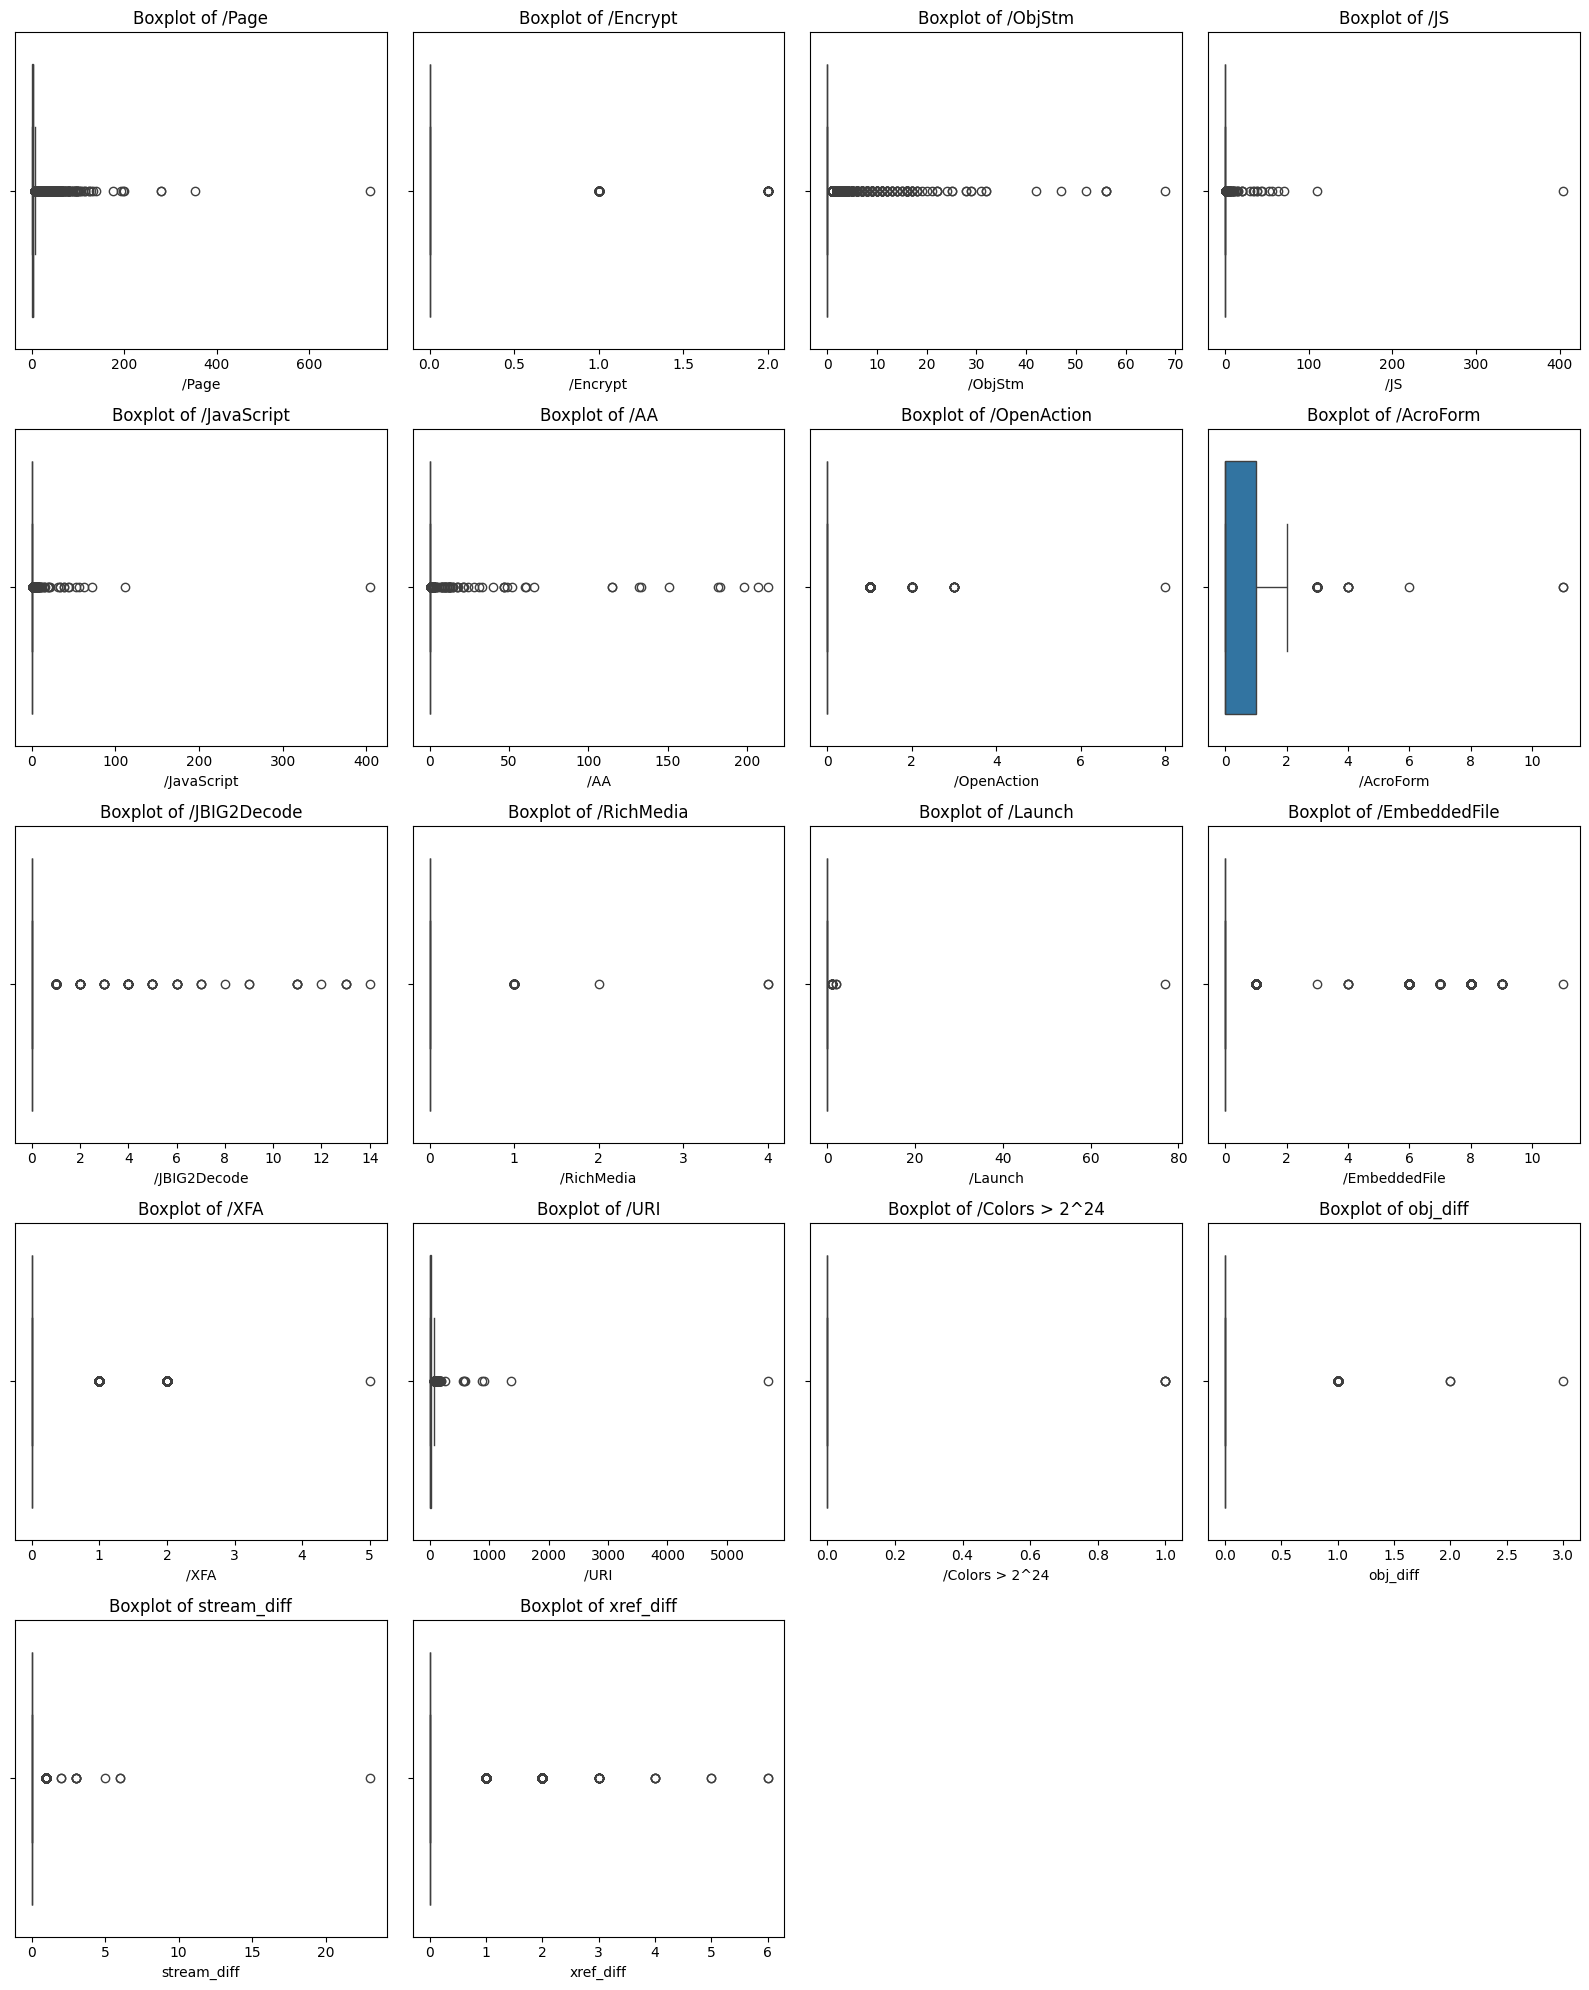

In [ ]:
feature_columns_numeric = df_feature.select_dtypes(include=np.number).columns.tolist()
if 'label' in feature_columns_numeric:
    feature_columns_numeric.remove('label')

if 'size' in feature_columns_numeric:
    feature_columns_numeric.remove('size')

n_features = len(feature_columns_numeric)
n_cols = 4
n_rows = math.ceil(n_features / n_cols)

plt.figure(figsize=(n_cols * 4, n_rows * 4))

for i, feature in enumerate(feature_columns_numeric):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=df_feature[feature])
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)

plt.tight_layout()
plt.show()


이상치를 탐지하기 위해 boxplot으로 시각화 후 탐지한다.


-> 대부분 5~15%는 이상치를 갖고 있다.

In [ ]:
feature_columns_numeric = df_feature.select_dtypes(include=np.number).columns.tolist()
if 'label' in feature_columns_numeric:
    feature_columns_numeric.remove('label')
if 'size' in feature_columns_numeric:
    feature_columns_numeric.remove('size')

outlier_counts = {}

print("이상치의 수:")

for feature in feature_columns_numeric:
    Q1 = df_feature[feature].quantile(0.25)
    Q3 = df_feature[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    num_outliers = df_feature[(df_feature[feature] < lower_bound) | (df_feature[feature] > upper_bound)].shape[0]

    outlier_counts[feature] = num_outliers
    print(f"- {feature}: {num_outliers}")

이상치의 수:
- /Page: 2046
- /Encrypt: 80
- /ObjStm: 1474
- /JS: 4442
- /JavaScript: 4490
- /AA: 463
- /OpenAction: 2897
- /AcroForm: 48
- /JBIG2Decode: 123
- /RichMedia: 46
- /Launch: 30
- /EmbeddedFile: 2960
- /XFA: 4092
- /URI: 151
- /Colors > 2^24: 4
- obj_diff: 108
- stream_diff: 808
- xref_diff: 4086


Histograms for each feature's value counts (excluding zero) with counts on bars:


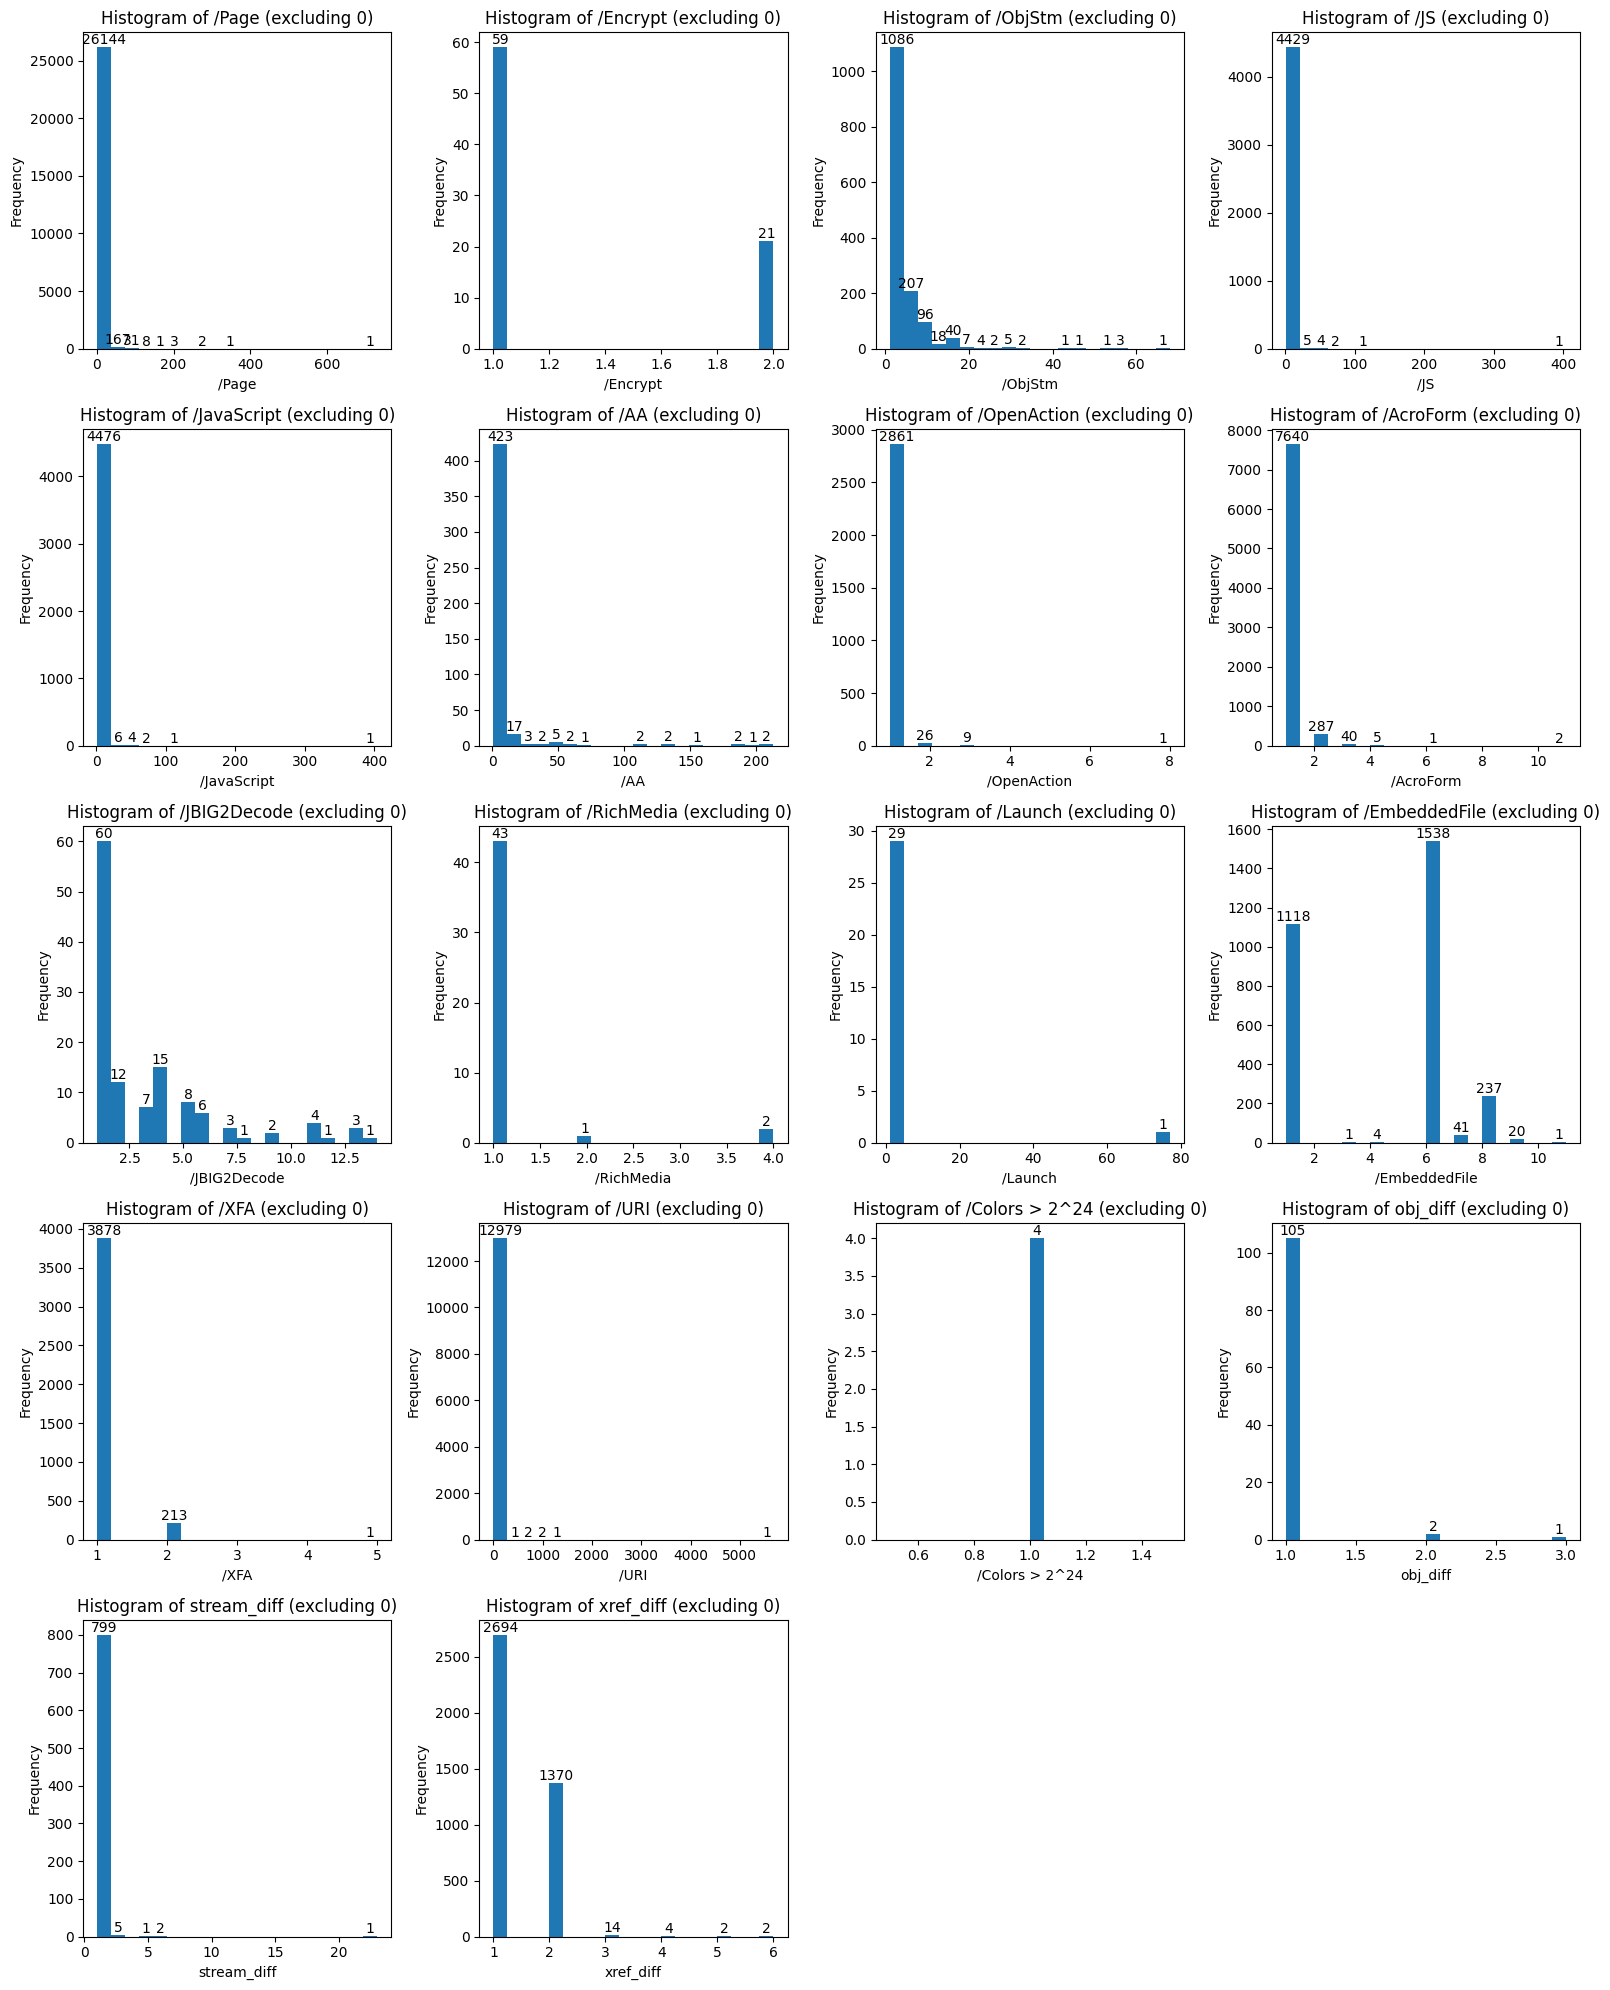

In [ ]:
feature_columns = df_feature.select_dtypes(include=np.number).columns.tolist()
columns_to_exclude = ['label', 'source', 'is_pdf', 'error', 'size']
features_to_plot = [col for col in feature_columns if col not in columns_to_exclude]

print("Histograms for each feature's value counts (excluding zero) with counts on bars:")

n_features = len(features_to_plot)
n_cols = 4
n_rows = math.ceil(n_features / n_cols)

plt.figure(figsize=(n_cols * 4, n_rows * 4))

for i, feature in enumerate(features_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    data = df_feature[df_feature[feature] != 0][feature]
    counts, bins, patches = plt.hist(data, bins=20)

    for count, patch in zip(counts, patches):
        if count > 0:
            plt.text(patch.get_x() + patch.get_width() / 2.,
                     patch.get_height(),
                     int(count),
                     ha='center',
                     va='bottom')

    plt.title(f'Histogram of {feature} (excluding 0)')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

이상치 또한 악성파일의 특징이므로 결국 처리하지 않았다.

## 인코딩

In [ ]:
df_feature['has_MZ'] = df_feature['has_MZ'].astype(int)
df_feature['has_PK'] = df_feature['has_PK'].astype(int)

df_feature

,label,source,is_pdf,error,size,/Page,/Encrypt,/ObjStm,/JS,/JavaScript,/AA,/OpenAction,/AcroForm,/JBIG2Decode,/RichMedia,/Launch,/EmbeddedFile,/XFA,/URI,/Colors > 2^24,has_MZ,has_PK,obj_diff,stream_diff,xref_diff
filename,,,,,,,,,,,,,,,,,,,,,,,,,
rp-11-41.pdf,0,CIC,True,False,65867.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
rp-09-51.pdf,0,CIC,True,False,16457.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
n-10-69.pdf,0,CIC,True,False,15739.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
f8594.pdf,0,CIC,True,False,87068.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.0,0.0,0.0
n-09-50.pdf,0,CIC,True,False,46393.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VirusShare_280d5f39c217d8501626adc86221c752,1,virustotal,True,False,369652.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0,0,0.0,0.0,0.0
VirusShare_c1bbc46bc72890d301469dd7d281b019,1,virustotal,True,False,92201.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.0
VirusShare_8c831c5f1b28e66f132385692aebe59c,1,virustotal,True,False,12327.0,1.0,0.0,0.0,2.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,1.0


## 정규화

내가 사용할 random forest는 수치가 중요한 것이 아니라 수치 간 대소관계가 중요하므로 정규화는 불필요하다.

### 데이터 저장

In [8]:
# 오염 방지로 주석 처리
# 이젠 여기서부터 돌리기
#df_feature.to_csv(colab_path + 'data_feature/feature_processed.csv')
df_feature = pd.read_csv(colab_path + "data_feature/feature_processed.csv", index_col='filename')

이상치 또한 악성파일의 특징이므로 결국 처리하지 않았다.

# 탐색적 분석

## feature 간 상관계수 확인

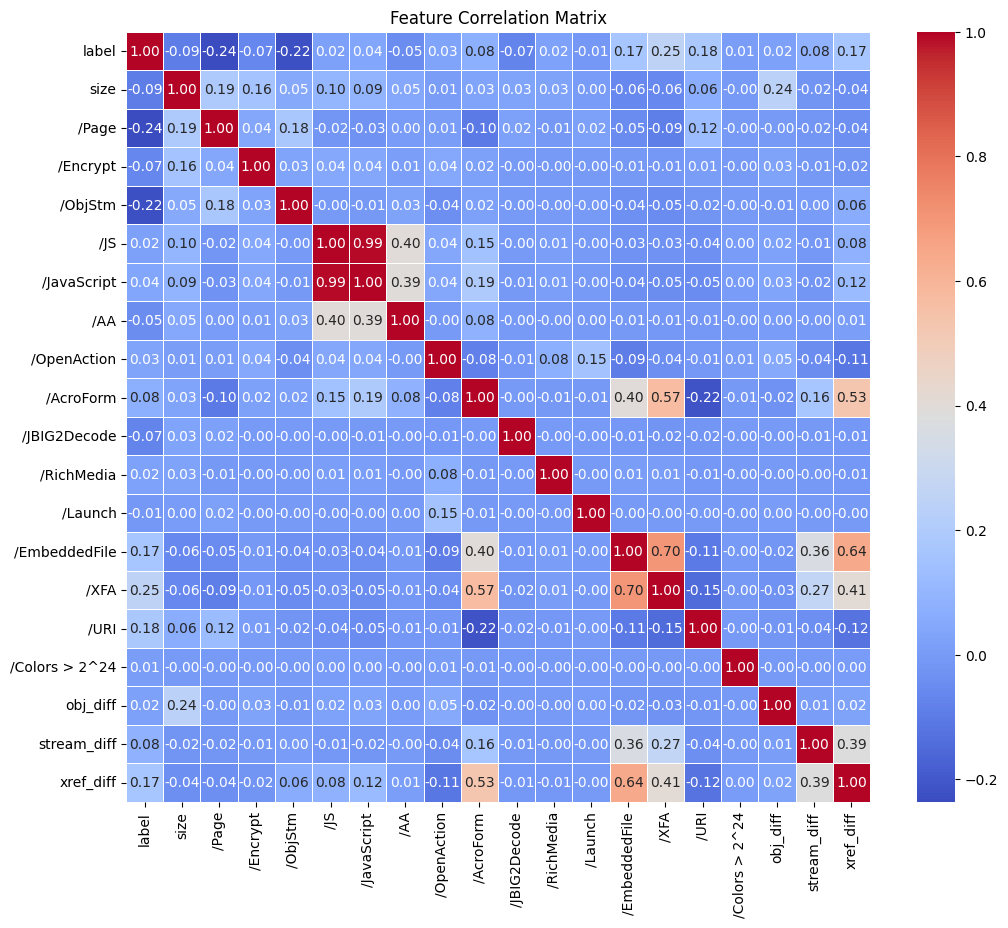

In [ ]:
feature_columns = [col for col in df_feature.columns if col not in ['source', 'is_pdf', 'error']] # 상관관계에서 제외할 것

correlation_matrix = df_feature[feature_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Feature Correlation Matrix')
plt.show()

# 모델 학습

## Random Forest

### 악성 가중치 주기 전

Hyperparameter tuning complete.
Best parameters found: {'max_depth': 12, 'min_samples_split': 5, 'n_estimators': 200}
Best F1 score from cross-validation: 0.9937

Accuracy on the test set (with best model): 0.9916
F1 Score on the test set (with best model): 0.9942


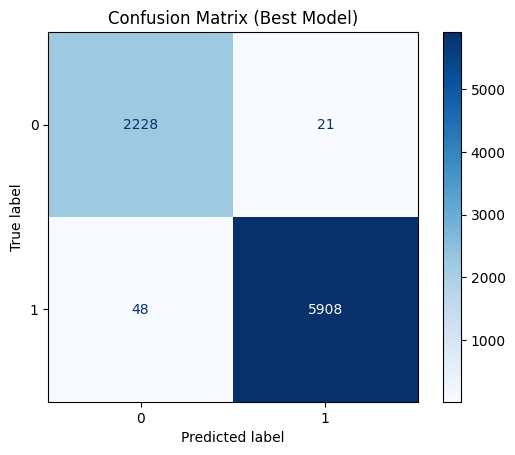

In [9]:
feature_columns = [col for col in df_feature.columns if col not in ['label', 'source', 'is_pdf', 'error']]
X = df_feature[feature_columns]
y = df_feature['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 8, 12],
    'min_samples_split': [2, 5, 10]
}

# 5-fold
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='f1',
                           cv=cv_strategy,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Hyperparameter tuning complete.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best F1 score from cross-validation: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"\nAccuracy on the test set (with best model): {accuracy:.4f}")
print(f"F1 Score on the test set (with best model): {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Best Model)')
plt.show()

model = best_model

### 악성 가중치 준 후

Hyperparameter tuning complete.
Best parameters found: {'class_weight': {0: 1, 1: 5}, 'max_depth': 12, 'min_samples_split': 5, 'n_estimators': 200}
Best F1 score from cross-validation: 0.9934

Accuracy on the test set (with best model): 0.9927
F1 Score on the test set (with best model): 0.9950


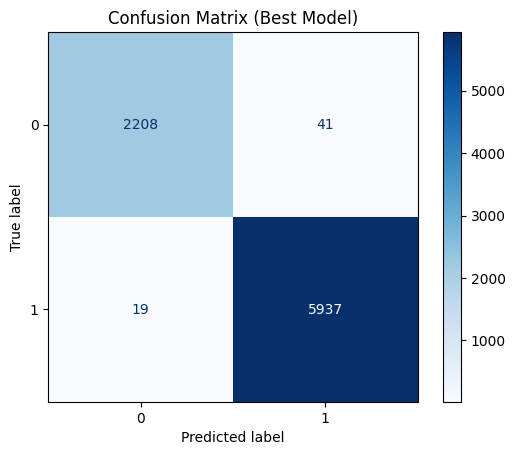

In [ ]:
feature_columns = [col for col in df_feature.columns if col not in ['label', 'source', 'is_pdf', 'error']]
X = df_feature[feature_columns]
y = df_feature['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 8, 12],
    'min_samples_split': [2, 5, 10],
    'class_weight': [{0: 1, 1: 5}] # <- FNR을 줄이기 위해 악성(1)에 가중치
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='f1',
                           cv=cv_strategy,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Hyperparameter tuning complete.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best F1 score from cross-validation: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"\nAccuracy on the test set (with best model): {accuracy:.4f}")
print(f"F1 Score on the test set (with best model): {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Best Model)')
plt.show()

# Store the best model
model = best_model

## 학습 결과 탐색

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Display classification report for more detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Evaluation Metrics:
Accuracy: 0.9927
Precision: 0.9931
Recall: 0.9968
F1 Score: 0.9950

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2249
           1       0.99      1.00      0.99      5956

    accuracy                           0.99      8205
   macro avg       0.99      0.99      0.99      8205
weighted avg       0.99      0.99      0.99      8205



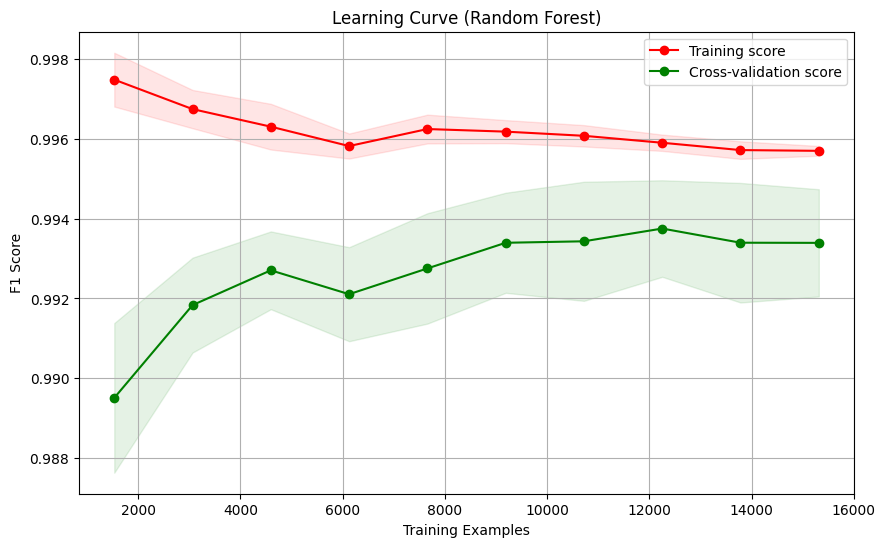

In [ ]:
# learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    cv=cv_strategy,
    scoring='f1',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.title("Learning Curve (Random Forest)")
plt.xlabel("Training Examples")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.grid()
plt.show()

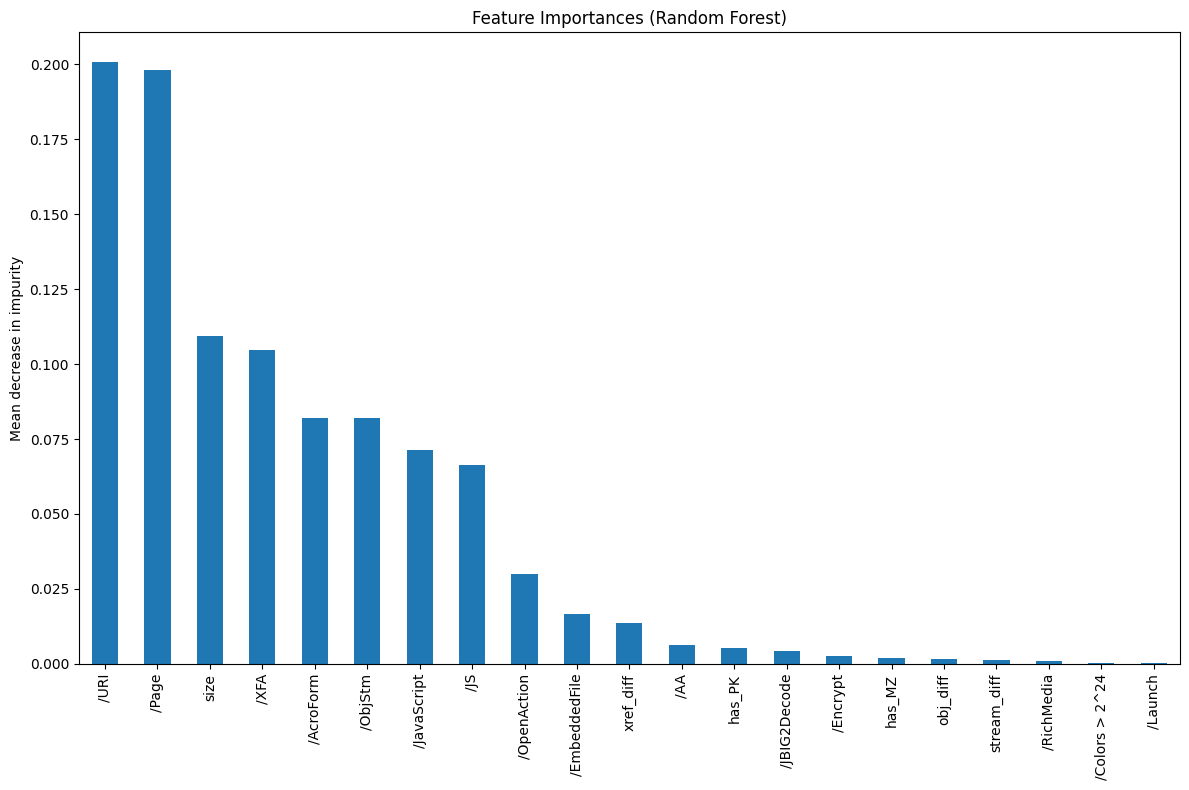

In [39]:
# 중요한 feature 보여주기
if 'model' in locals() and model is not None:
    importances = model.feature_importances_
    feature_names = X_train.columns
    forest_importances = pd.Series(importances, index=feature_names)

    fig, ax = plt.subplots(figsize=(12, 8))
    forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
    ax.set_title("Feature Importances (Random Forest)")
    ax.set_ylabel("Mean decrease in impurity")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

F1 Score (RandomForest): 0.9950


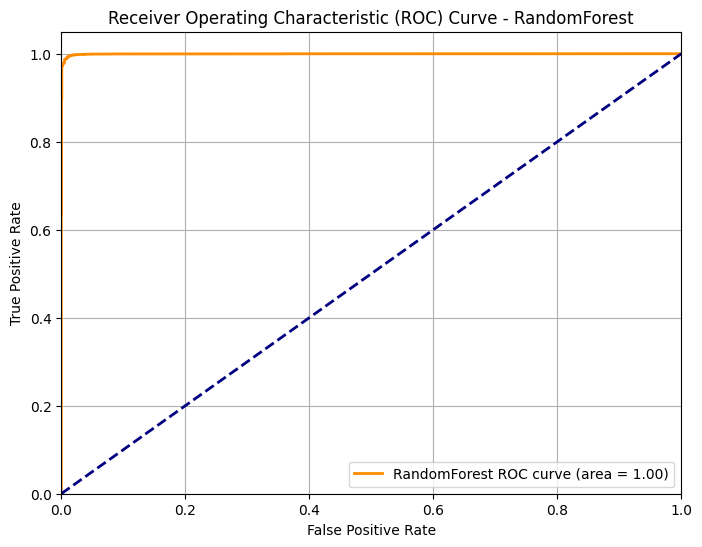

In [ ]:
# ROC curve
f1_rf = f1_score(y_test, y_pred)
print(f"F1 Score (RandomForest): {f1_rf:.4f}")


y_pred_proba_rf = model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'RandomForest ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - RandomForest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


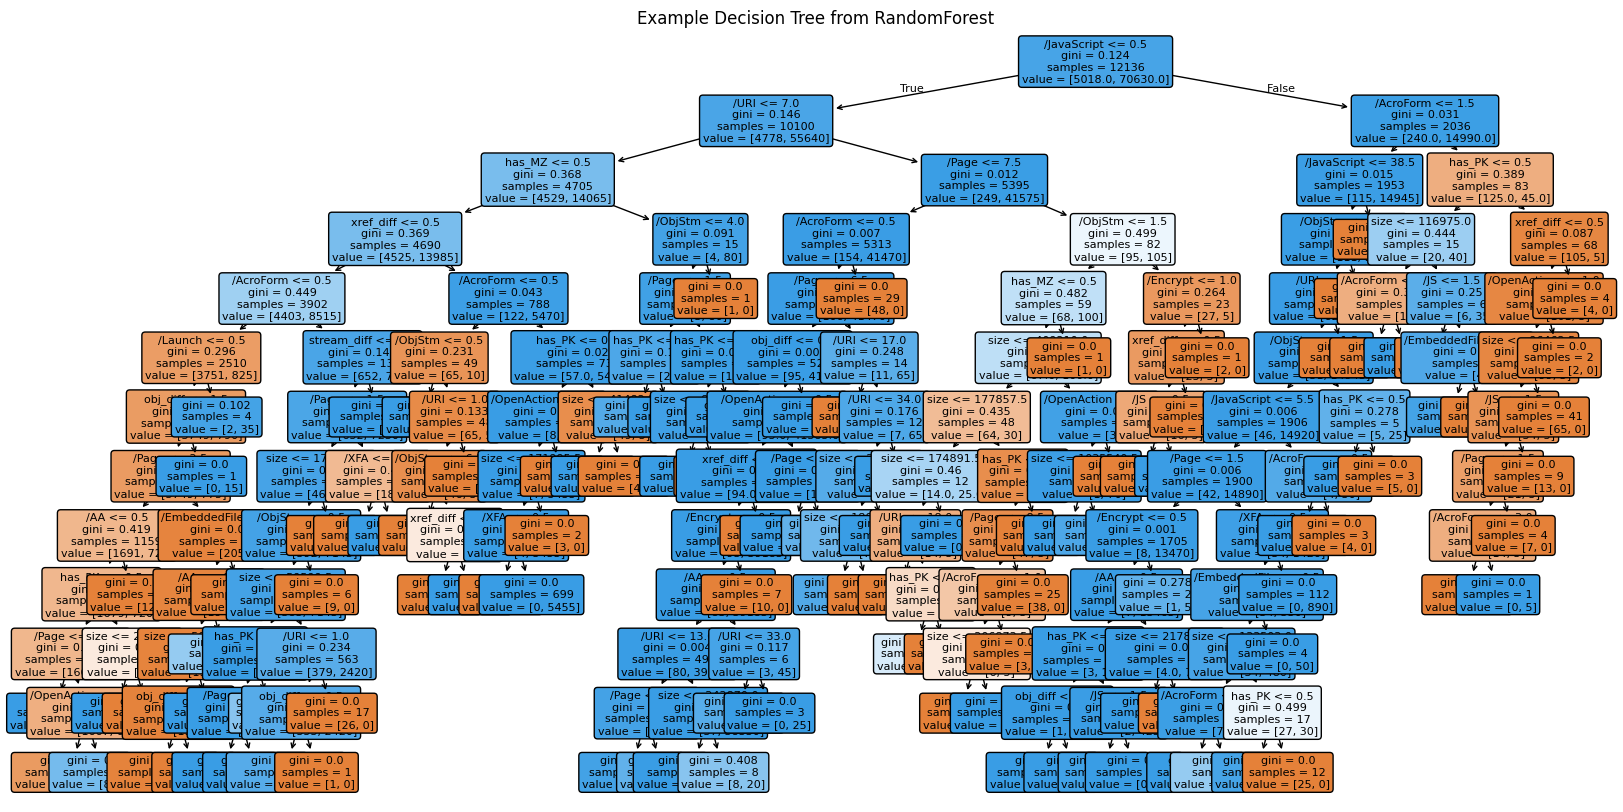

In [ ]:
if 'model' in locals() and model is not None:
    single_tree = model.estimators_[0]

    plt.figure(figsize=(20, 10))
    plot_tree(single_tree, feature_names=X.columns.tolist(), filled=True, rounded=True, fontsize=8)
    plt.title("Example Decision Tree from RandomForest")
    plt.show()

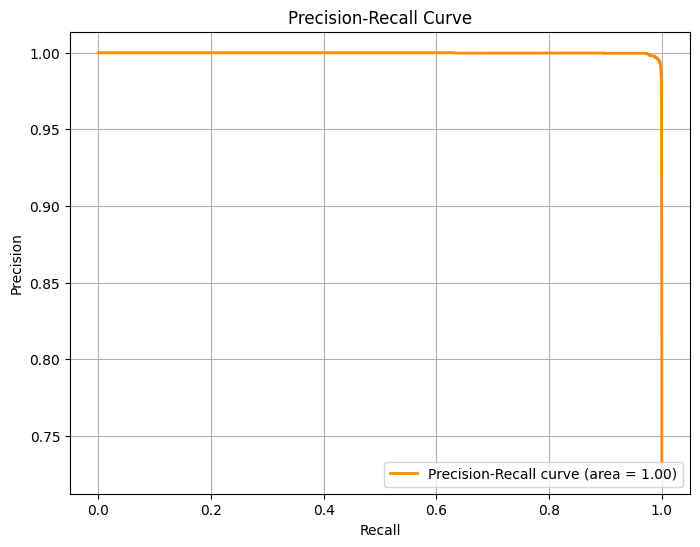

In [10]:
model_filename = colab_path + '/model/model_randomforest_weighted.pkl'
with open(model_filename, 'rb') as file:
    model = pickle.load(file)

# Predict probabilities on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate Precision-Recall curve and AUC-PR
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auc_pr = average_precision_score(y_test, y_pred_proba)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Precision-Recall curve (area = {auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
model_filename = colab_path + '/model/model_randomforest_weighted.pkl'
with open(model_filename, 'wb') as file:
    #pickle.dump(model, file)
    pass